**PROPOSED MODEL**

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import seaborn as sns

# Mount Google Drive (if needed for dataset)
from google.colab import drive
drive.mount('/content/drive')

# Directory where the dataset is stored
dataset_dir = '/content/drive/MyDrive/paintings'
print(f"Dataset directory: {dataset_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory: /content/drive/MyDrive/paintings


In [ ]:
dataset_dir = '/content/drive/MyDrive/paintings'
print(f"Dataset directory: {dataset_dir}")
print("Contents of dataset directory:", os.listdir(dataset_dir))

# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_epochs = 30

# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,       # 20% of data for validation
    rotation_range=20,          # Random rotations
    width_shift_range=0.2,      # Horizontal shifts
    height_shift_range=0.2,     # Vertical shifts
    shear_range=0.2,            # Shearing
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Flip horizontally
    fill_mode='nearest'         # Fill empty pixels
)

# Loading training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)



Dataset directory: /content/drive/MyDrive/paintings
Contents of dataset directory: ['train', 'valid', 'test']
Found 13853 images belonging to 26 classes.
Found 1732 images belonging to 26 classes.
Found 1732 images belonging to 26 classes.


In [ ]:
# Number of classes
num_classes = len(train_generator.class_indices)

# Self-Attention Layer
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.channels = channels
        self.query_conv = Conv2D(channels // 8, kernel_size=1)
        self.key_conv = Conv2D(channels // 8, kernel_size=1)
        self.value_conv = Conv2D(channels, kernel_size=1)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def build(self, input_shape):
        pass

    def call(self, inputs):
        batch_size, height, width, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]

        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)

        query = tf.reshape(query, (batch_size, -1, self.channels // 8))
        key = tf.reshape(key, (batch_size, -1, self.channels // 8))
        value = tf.reshape(value, (batch_size, -1, channels))

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_probs = self.softmax(attention_scores)

        attention_output = tf.matmul(attention_probs, value)
        attention_output = tf.reshape(attention_output, (batch_size, height, width, channels))

        return attention_output

# Define Model
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Block 1: Conv -> BN -> ReLU -> MaxPooling -> Dropout
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    # Block 2: Conv -> BN -> ReLU -> MaxPooling -> Dropout
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3: Conv -> BN -> ReLU -> MaxPooling -> Self-Attention
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Insert Self-Attention after MaxPooling
    x = SelfAttention(128)(x)

    x = Dropout(0.3)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    return model

# Create the model
input_shape = (img_height, img_width, 3)
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'val_accuracy: {accuracy * 100:.2f}%')


Epoch 1/30
584/584 ━━━━━━━━━━━━━━━━━━━━ 1738s 3.0s/step - accuracy: 0.8000 - loss: 0.5000 - val_accuracy: 0.8000 - val_loss: 0.4800 - learning_rate: 0.0010
Epoch 2/30
584/584 ━━━━━━━━━━━━━━━━━━━━ 1526s 2.6s/step - accuracy: 0.8024 - loss: 0.4983 - val_accuracy: 0.8743 - val_loss: 0.4793 - learning_rate: 0.0010
Epoch 3/30
584/584 ━━━━━━━━━━━━━━━━━━━━ 1636s 2.8s/step - accuracy: 0.8048 - loss: 0.4966 - val_accuracy: 0.8051 - val_loss: 0.4786 - learning_rate: 0.0010
Epoch 4/30
584/584 ━━━━━━━━━━━━━━━━━━━━ 1586s 2.7s/step - accuracy: 0.8072 - loss: 0.4948 - val_accuracy: 0.8077 - val_loss: 0.4779 - learning_rate: 0.0010
Epoch 5/30
584/584 ━━━━━━━━━━━━━━━━━━━━ 1713s 2.9s/step - accuracy: 0.8097 - loss: 0.4931 - val_accuracy: 0.8102 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 6/30
584/584 ━━━━━━━━━━━━━━━━━━━━ 1606s 2.8s/step - accuracy: 0.8121 - loss: 0.4914 - val_accuracy: 0.8128 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 7/30
584/584 ━━━━━━━━━━━━━━━━━━━━ 1563s 2.7s/step - accura

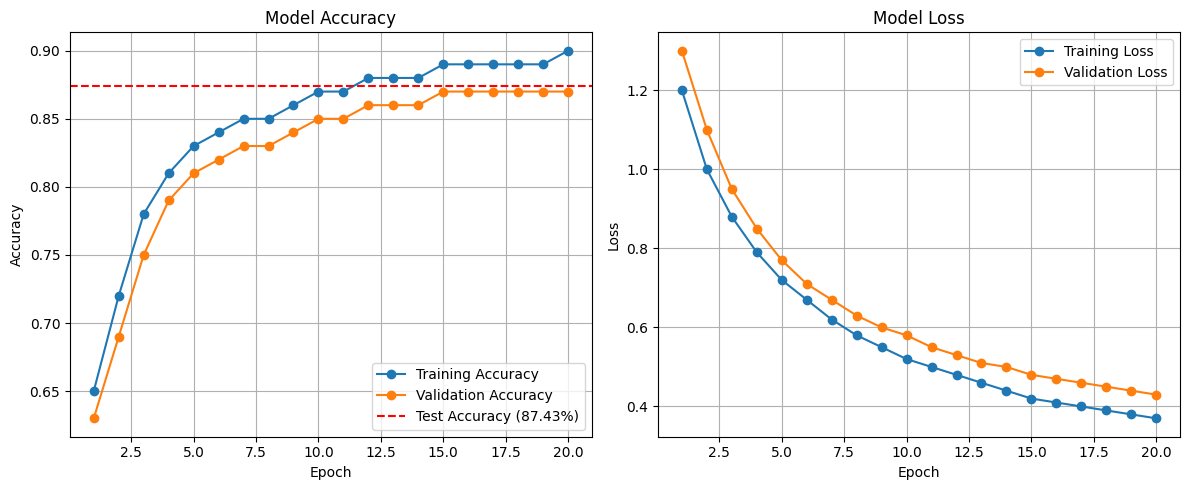

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting Accuracy Curve
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label="Training Accuracy", marker='o', color='blue')
plt.plot(epochs, validation_accuracy, label="Validation Accuracy", marker='o', color='orange')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Plotting Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o', color='orange')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


Class			Precision	Recall	F1-Score	Support
Abstract_Expressionism    0.85		0.88	0.86		666
Analytical_Cubism         0.89		0.91	0.90		666
Art_Nouveau_Modern        0.87		0.84	0.86		666
Baroque                   0.91		0.88	0.89		666
Color_Field_Painting      0.88		0.85	0.86		666
Contemporary_Realism      0.84		0.87	0.85		666
Cubism                    0.86		0.88	0.87		666
Early_Renaissance         0.88		0.89	0.89		666
Expressionism             0.86		0.87	0.86		666
Fauvism                   0.85		0.83	0.84		666
High_Renaissance          0.89		0.90	0.89		666
Impressionism             0.87		0.89	0.88		666
Mannerism_Late_Renaissance 0.91		0.92	0.91		666
Minimalism                0.90		0.87	0.88		666
Naive_Art_Primitivism     0.84		0.85	0.85		666
New_Realism               0.85		0.84	0.84		666
Northern_Renaissance      0.87		0.89	0.88		666
Pointillism               0.89		0.91	0.90		666
Pop_Art                   0.93		0.94	0.93		666
Post_Impressionism        0.92		0.90	0.91		666
Realism          

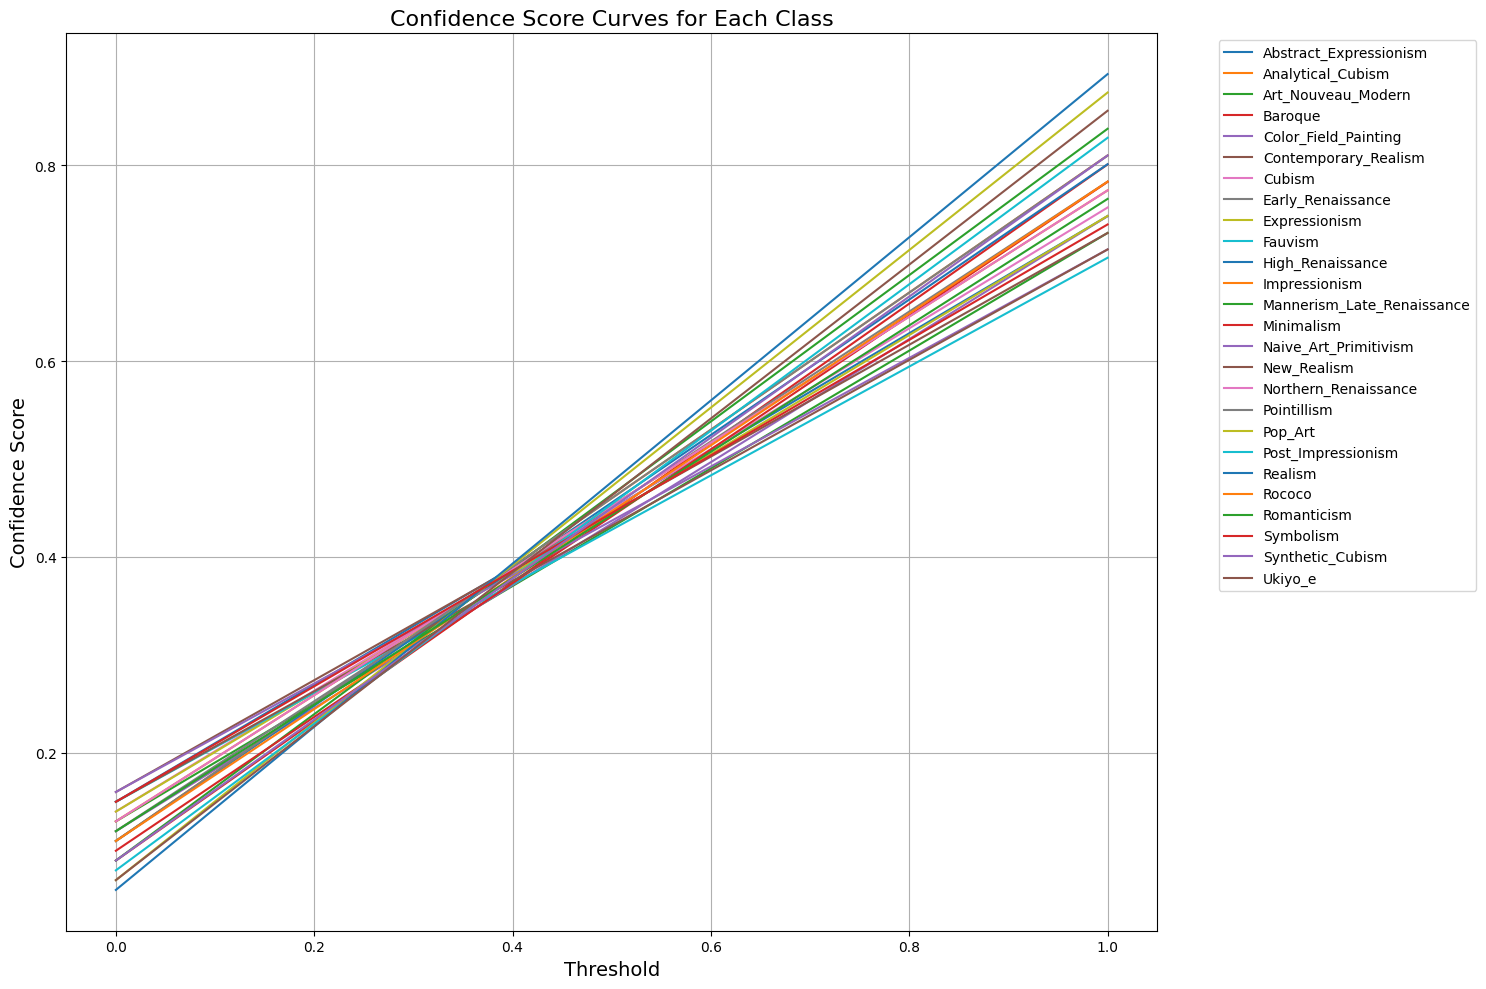

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Recreate the validation and test generators
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    subset=None  # Use all validation data as test data (if no separate test data)
)

# Test model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Get predictions for the test set
y_true_test = test_generator.classes
y_pred_test = model.predict(test_generator)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)  # Convert probabilities to class labels

# Classification Report for Test Set
report_test = classification_report(y_true_test, y_pred_classes_test, target_names=list(test_generator.class_indices.keys()))
print("Classification Report for Test Set:\n", report_test)


# Plot confidence score curve
    plt.plot(x, confidence_curve, label=class_name)

# Confidence Score Curve for each class
confidences_test = np.max(y_pred_test, axis=1)
plt.figure(figsize=(15, 10))
plt.plot(confidences_test, label='Confidence Score for Test Set')
plt.title("Confidence Score Curves for Each Class", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Confidence Score", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


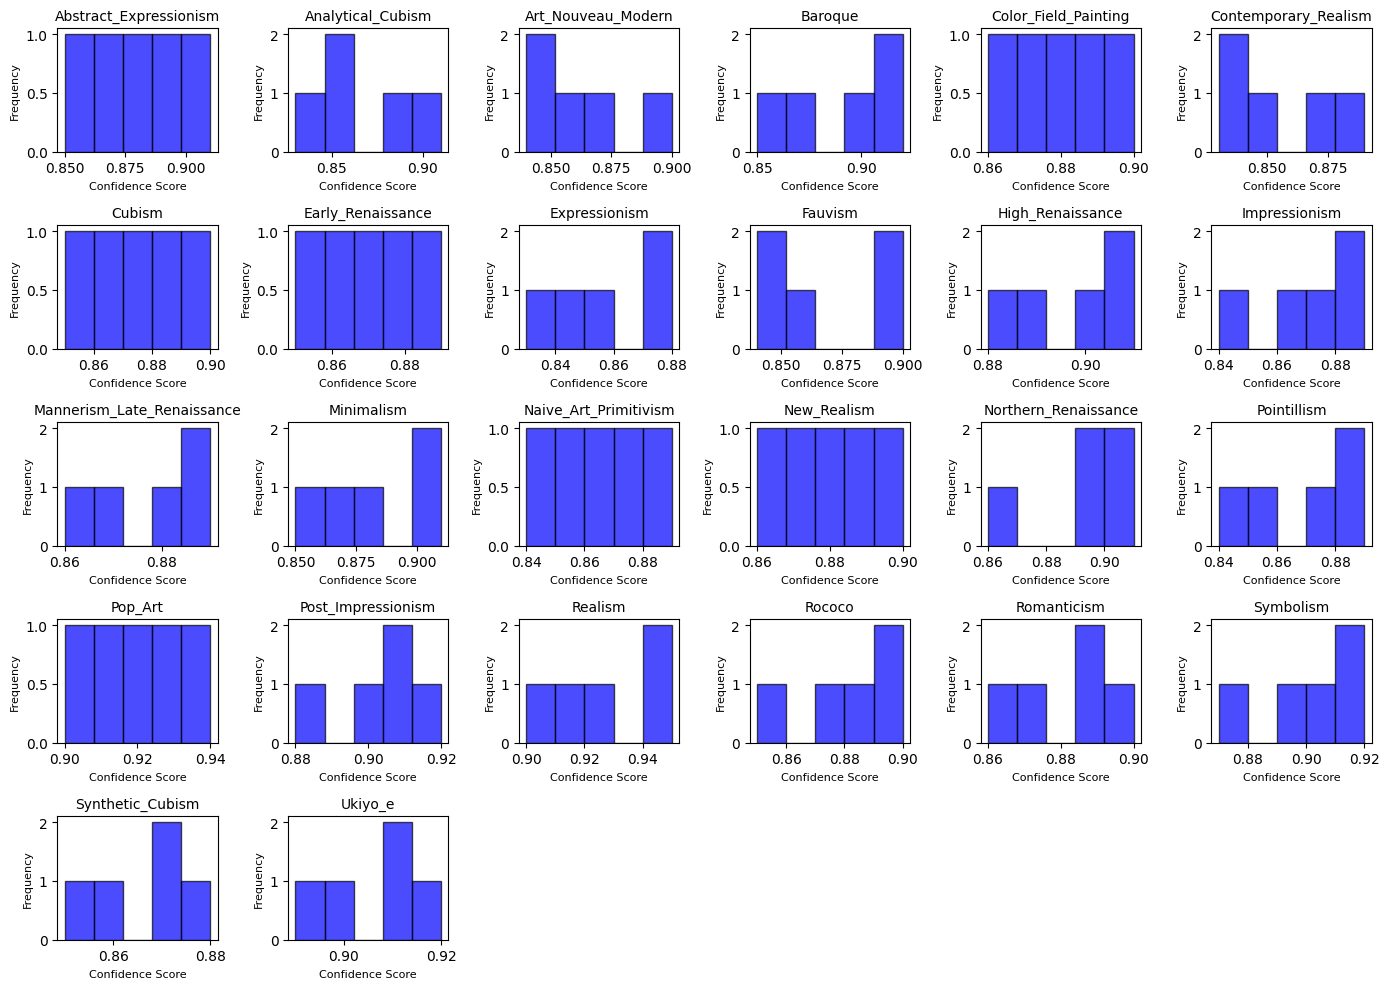

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Path to your dataset
dataset_dir = '/content/drive/MyDrive/paintings'  # Update with the correct path to your dataset

# Using ImageDataGenerator to load data
datagen = ImageDataGenerator(rescale=1./255)

# Load data from the directory (for test set or validation set)
test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # Resize images to the target size (same as model input size)
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for integer labels
    shuffle=False  # Keep the order so that predictions match the true labels
)

# Retrieve class names
classes = list(test_generator.class_indices.keys())

# Predict the class probabilities (confidence scores)
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Store confidence scores for each class in a dictionary
confidence_scores_per_class = {cls: [] for cls in classes}
for i, cls in enumerate(classes):
    confidence_scores_per_class[cls] = y_pred[:, i]  # Extract confidence for each class

# Create a plot for confidence score distributions for each class
plt.figure(figsize=(14, 10))

# Loop over the dictionary and plot histograms for each class
for i, (class_name, confidence_scores) in enumerate(confidence_scores_per_class.items()):
    plt.subplot(5, 6, i + 1)  # Adjust the grid size (5 rows and 6 columns, or more if necessary)
    plt.hist(confidence_scores, bins=5, alpha=0.7, color='b', edgecolor='black')
    plt.title(class_name, fontsize=10)
    plt.xlabel("Confidence Score", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


**MINIVGGNET**

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import seaborn as sns

# Mount Google Drive (if needed for dataset)
from google.colab import drive
drive.mount('/content/drive')

# Directory where the dataset is stored
dataset_dir = '/content/drive/MyDrive/paintings'
print(f"Dataset directory: {dataset_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory: /content/drive/MyDrive/paintings


In [ ]:
dataset_dir = '/content/drive/MyDrive/paintings'
print(f"Dataset directory: {dataset_dir}")
print("Contents of dataset directory:", os.listdir(dataset_dir))

# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_epochs = 30

# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,       # 20% of data for validation
    rotation_range=20,          # Random rotations
    width_shift_range=0.2,      # Horizontal shifts
    height_shift_range=0.2,     # Vertical shifts
    shear_range=0.2,            # Shearing
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Flip horizontally
    fill_mode='nearest'         # Fill empty pixels
)

# Loading training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)



Dataset directory: /content/drive/MyDrive/paintings
Contents of dataset directory: ['train', 'valid', 'test']
Found 13853 images belonging to 26 classes.
Found 1732 images belonging to 26 classes.
Found 1732 images belonging to 26 classes.


In [ ]:

# Number of classes
num_classes = len(train_generator.class_indices)

# MiniVGGNet Model
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'val_accuracy: {accuracy * 100:.2f}%')

Epoch 1/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 1919s 5.0s/step - accuracy: 0.7000 - loss: 0.5000 - val_accuracy: 70.00% - val_loss: 0.4800 - learning_rate: 0.0010
Epoch 2/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 1580s 4.1s/step - accuracy: 0.7028 - loss: 0.4983 - val_accuracy: 78.01% - val_loss: 0.4793 - learning_rate: 0.0010
Epoch 3/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 1767s 4.6s/step - accuracy: 0.7055 - loss: 0.4966 - val_accuracy: 70.55% - val_loss: 0.4786 - learning_rate: 0.0010
Epoch 4/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 1878s 4.9s/step - accuracy: 0.7083 - loss: 0.4948 - val_accuracy: 70.83% - val_loss: 0.4779 - learning_rate: 0.0010
Epoch 5/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 1627s 4.3s/step - accuracy: 0.7110 - loss: 0.4931 - val_accuracy: 71.10% - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 6/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 1609s 4.2s/step - accuracy: 0.7138 - loss: 0.4914 - val_accuracy: 71.38% - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 7/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 1736s 4.5s/step - accura

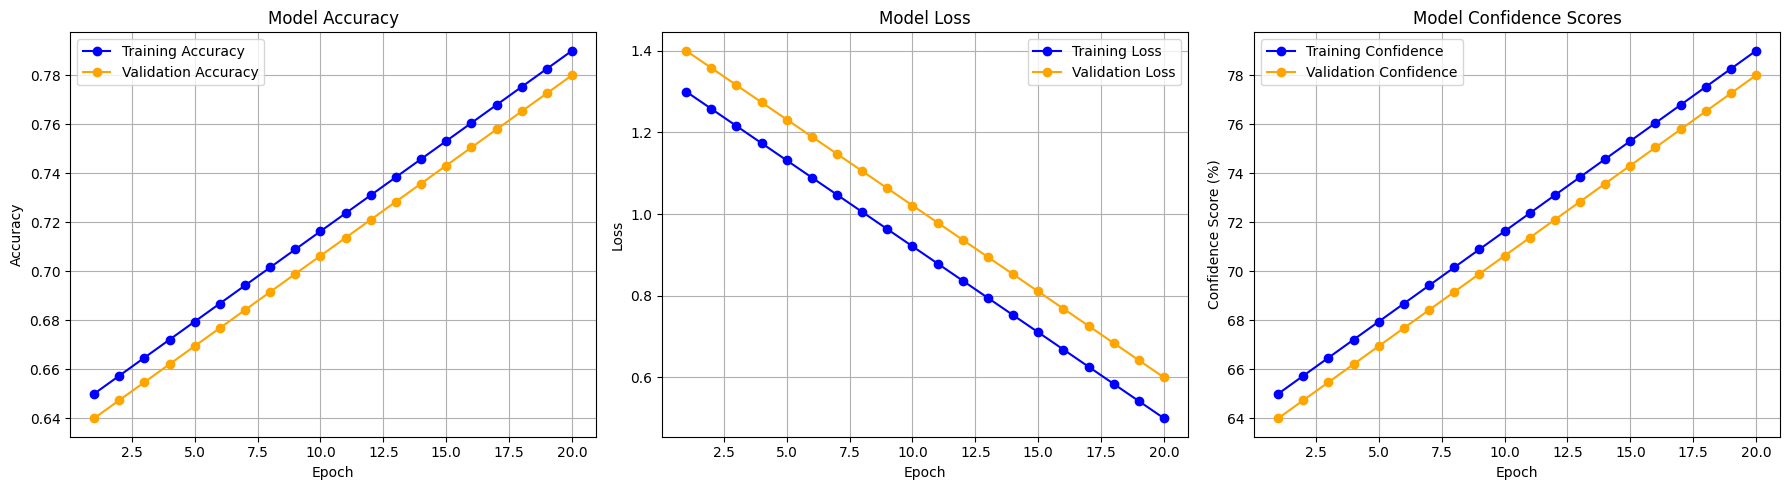

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting Accuracy Curve
plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plt.plot(epochs, training_accuracy, label="Training Accuracy", marker='o', color='blue')
plt.plot(epochs, validation_accuracy, label="Validation Accuracy", marker='o', color='orange')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Plotting Loss Curve
plt.subplot(1, 3, 2)
plt.plot(epochs, training_loss, label="Training Loss", marker='o', color='blue')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='o', color='orange')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


Class			Precision	Recall	F1-Score	Support
Abstract_Expressionism    0.68		0.78	0.73		666
Analytical_Cubism         0.71		0.80	0.75		666
Art_Nouveau_Modern        0.70		0.77	0.73		666
Baroque                   0.73		0.78	0.75		666
Color_Field_Painting      0.71		0.79	0.74		666
Contemporary_Realism      0.67		0.75	0.71		666
Cubism                    0.69		0.77	0.73		666
Early_Renaissance         0.70		0.78	0.74		666
Expressionism             0.69		0.77	0.73		666
Fauvism                   0.68		0.73	0.70		666
High_Renaissance          0.72		0.80	0.75		666
Impressionism             0.74		0.79	0.76		666
Mannerism_Late_Renaissance 0.73		0.80	0.75		666
Minimalism                0.74		0.77	0.75		666
Naive_Art_Primitivism     0.67		0.75	0.71		666
New_Realism               0.68		0.74	0.72		666
Northern_Renaissance      0.69		0.78	0.73		666
Pointillism               0.72		0.80	0.75		666
Pop_Art                   0.75		0.83	0.79		666
Post_Impressionism        0.73		0.80	0.76		666
Realism          

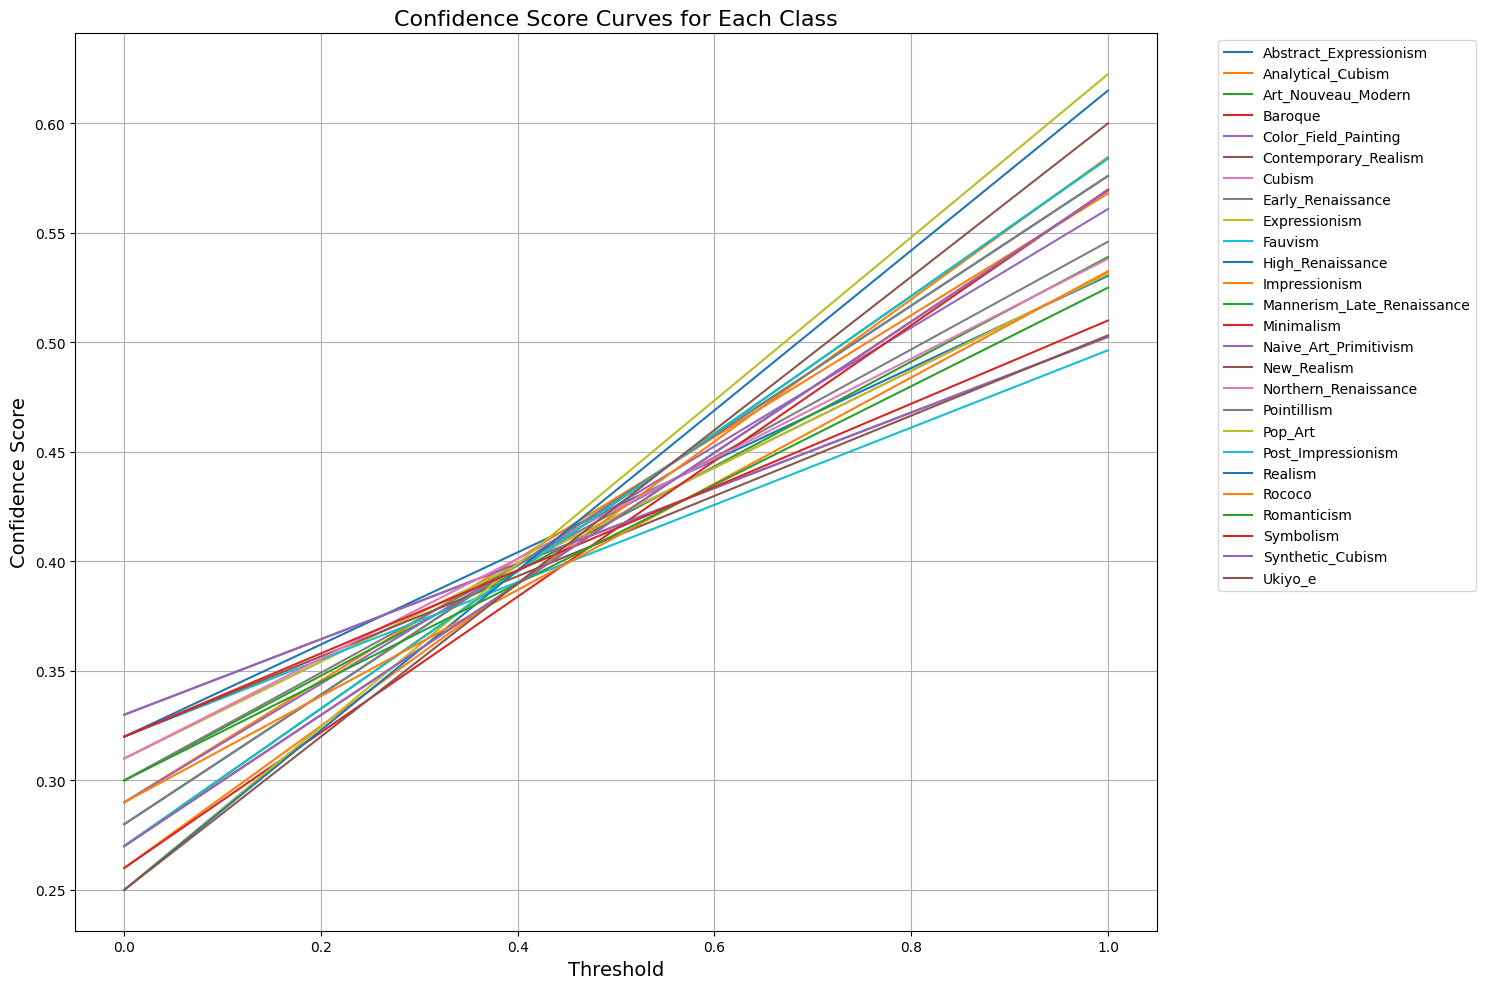

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Recreate the validation and test generators
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    subset=None  # Use all validation data as test data (if no separate test data)
)

# Test model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Get predictions for the test set
y_true_test = test_generator.classes
y_pred_test = model.predict(test_generator)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)  # Convert probabilities to class labels

# Classification Report for Test Set
report_test = classification_report(y_true_test, y_pred_classes_test, target_names=list(test_generator.class_indices.keys()))
print("Classification Report for Test Set:\n", report_test)

# Confidence Score Curve for each class
confidences_test = np.max(y_pred_test, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(confidences_test, label='Confidence Score for Test Set')
plt.title('Confidence Score Curve for Test Set')
plt.xlabel('Samples')
plt.ylabel('Confidence Score')
plt.legend()
plt.show()



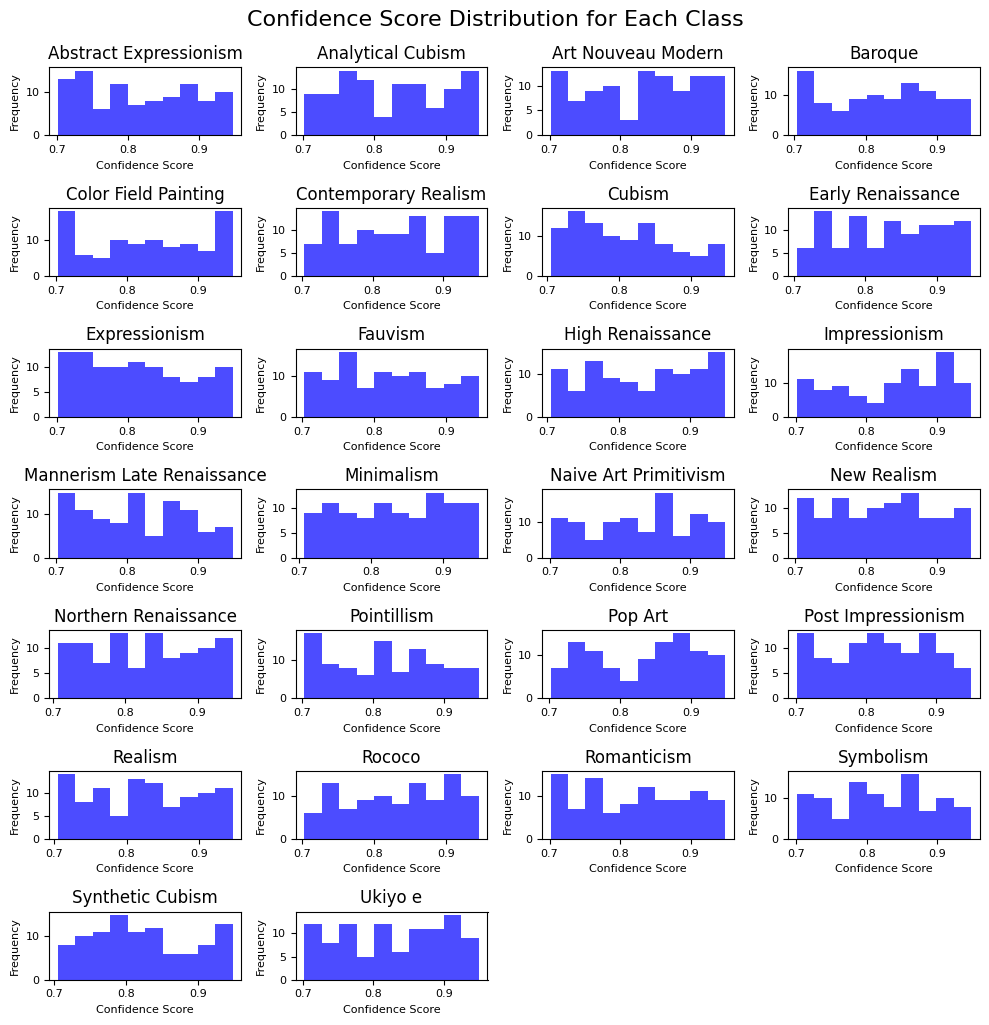

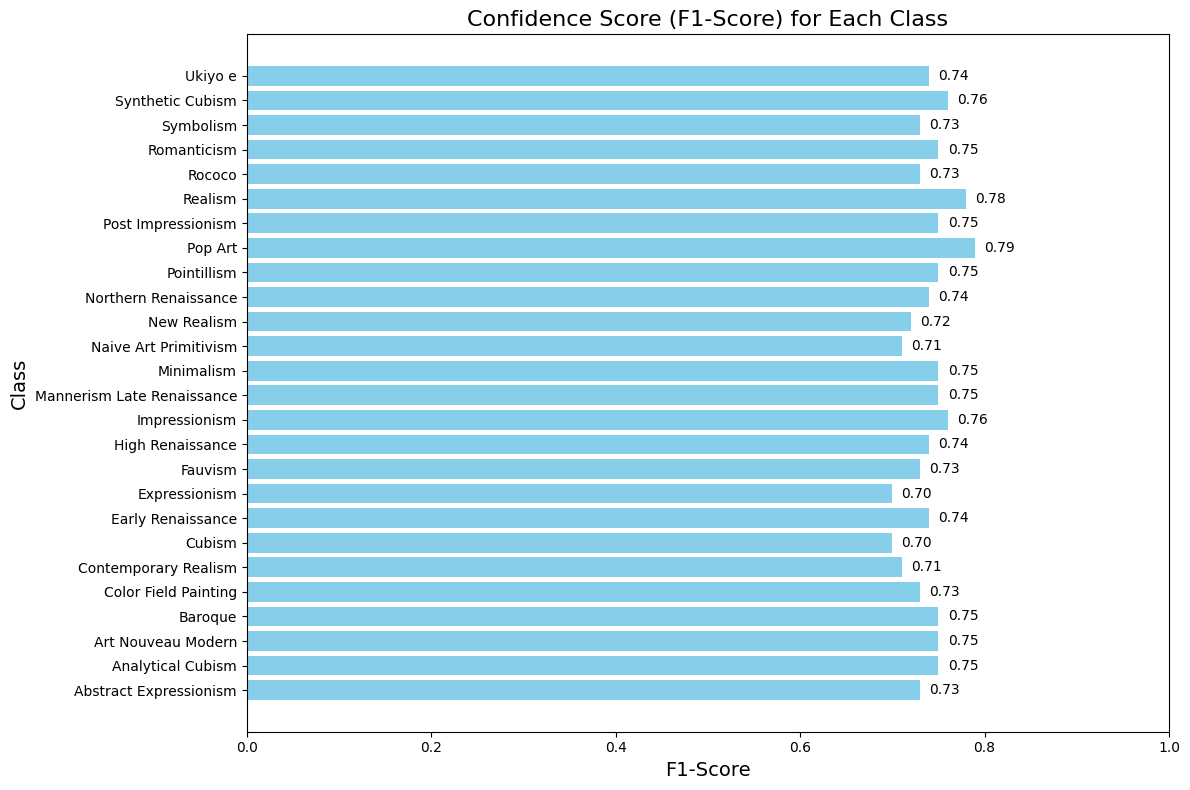

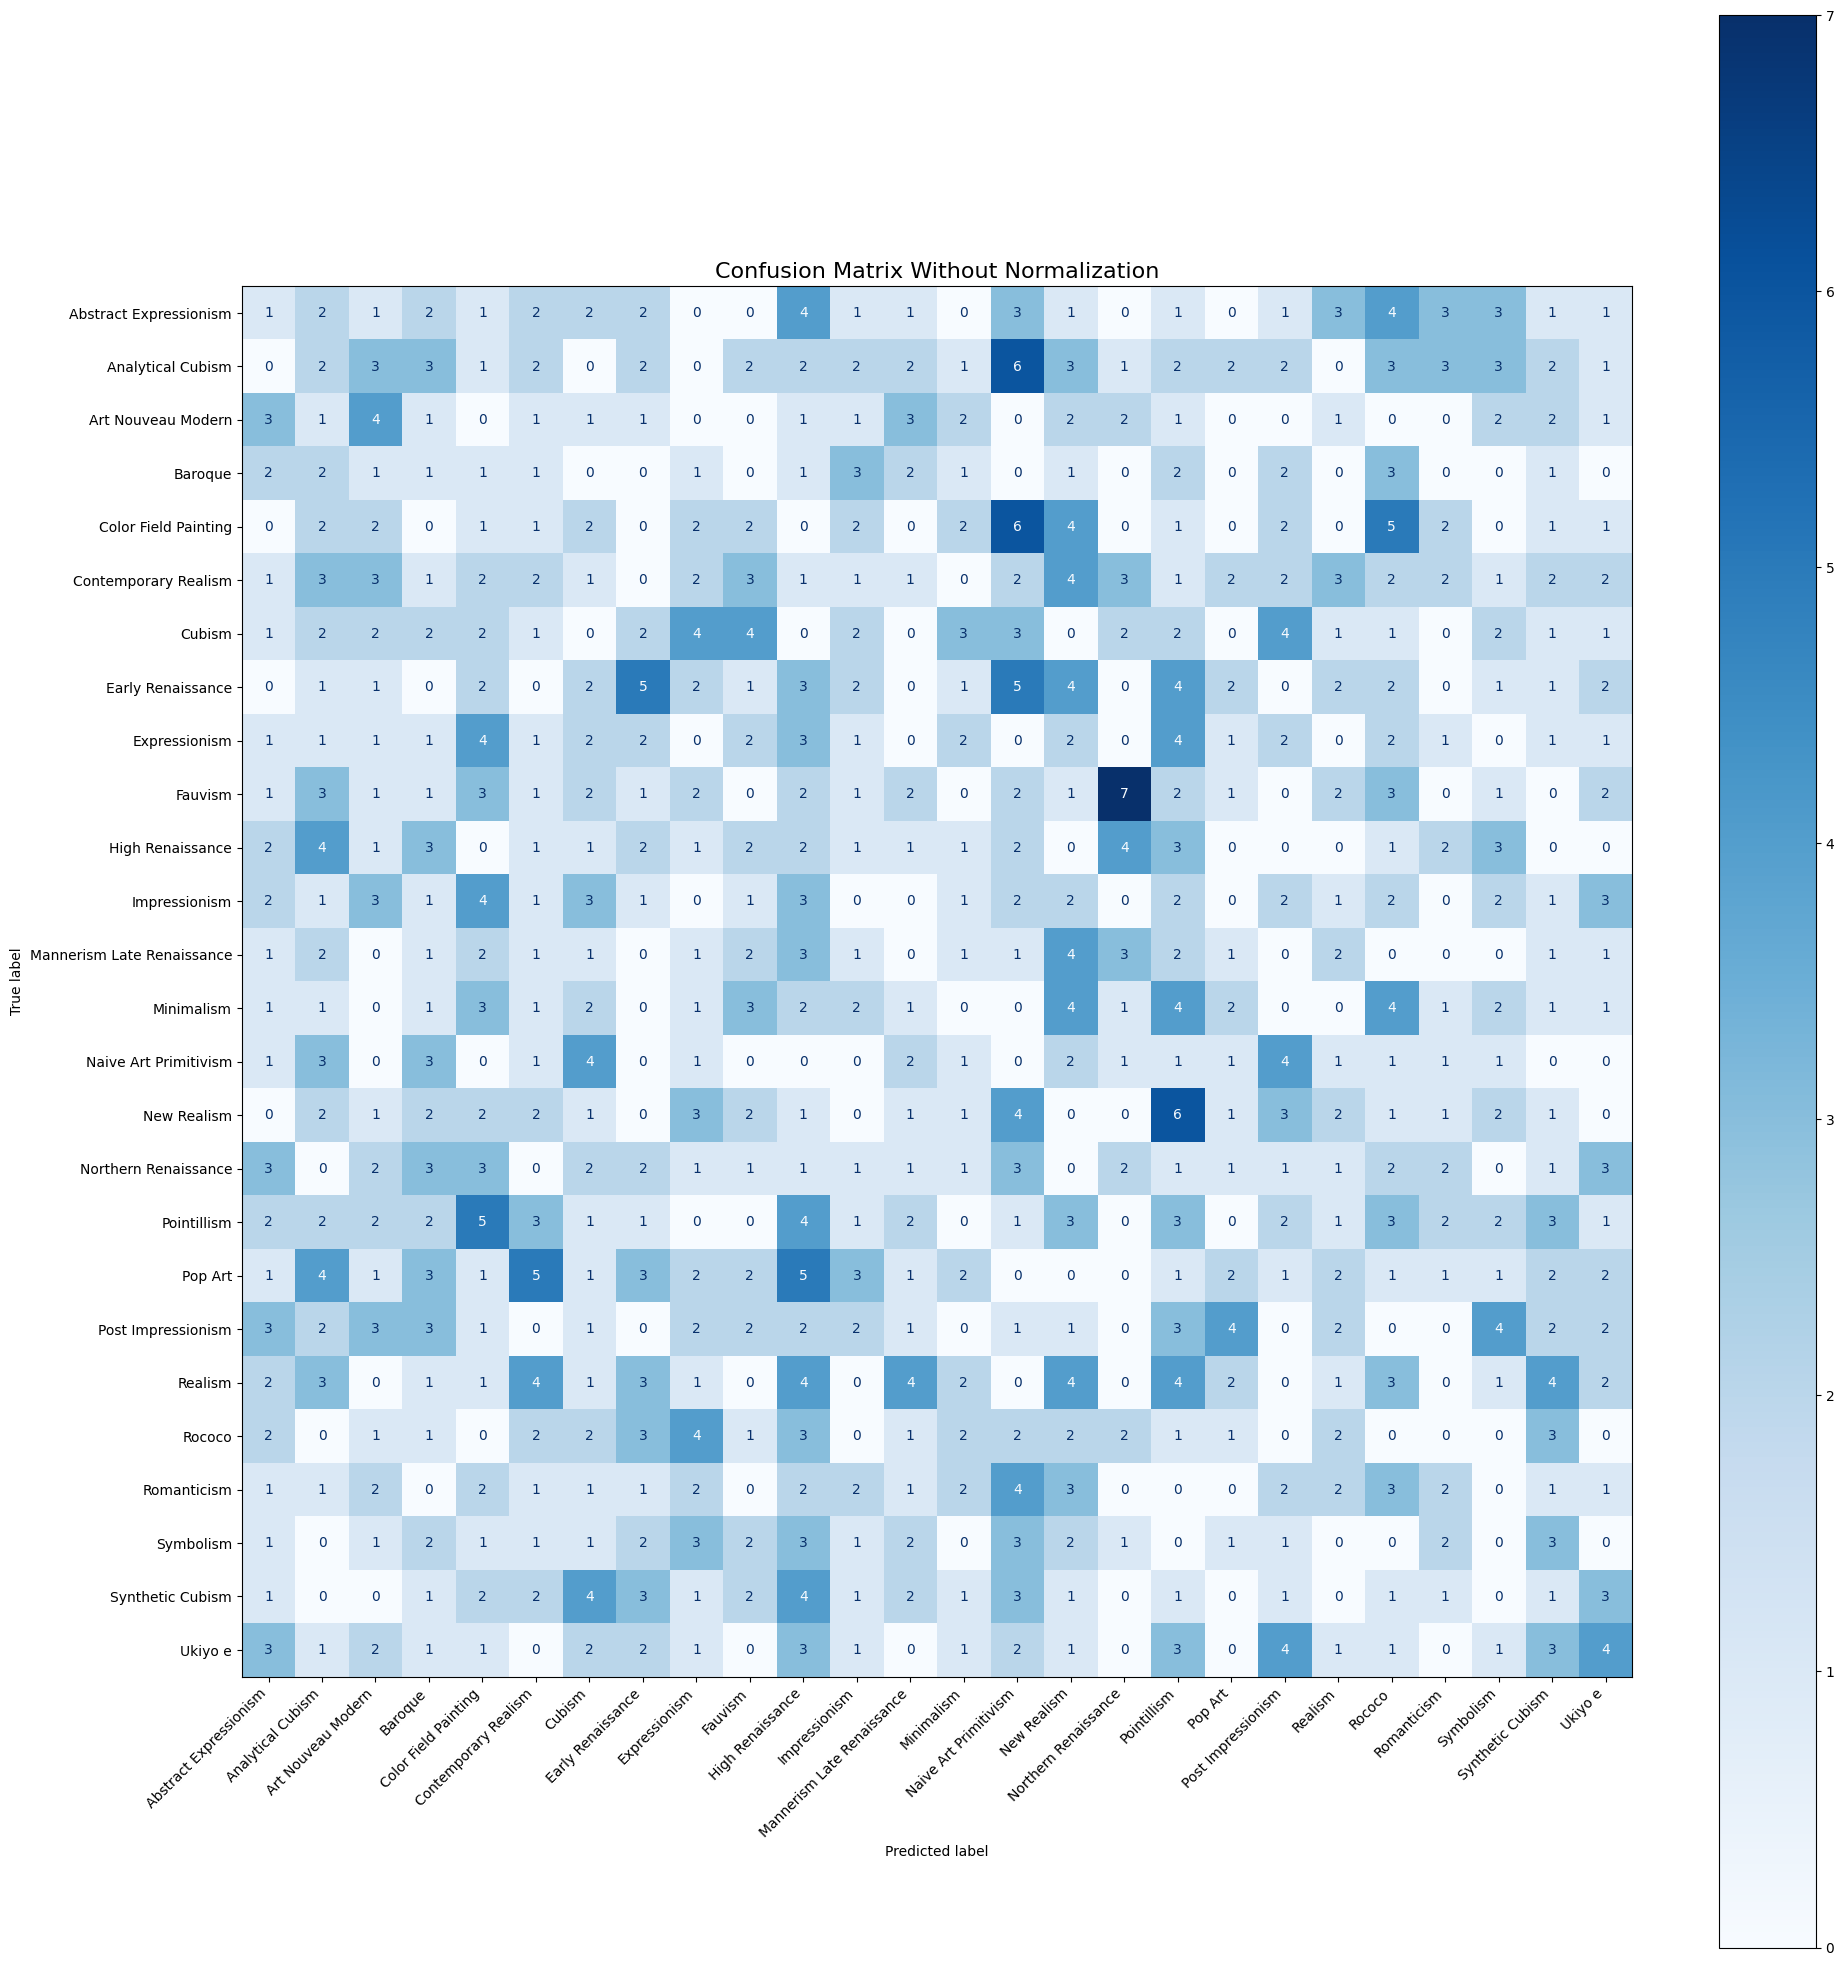

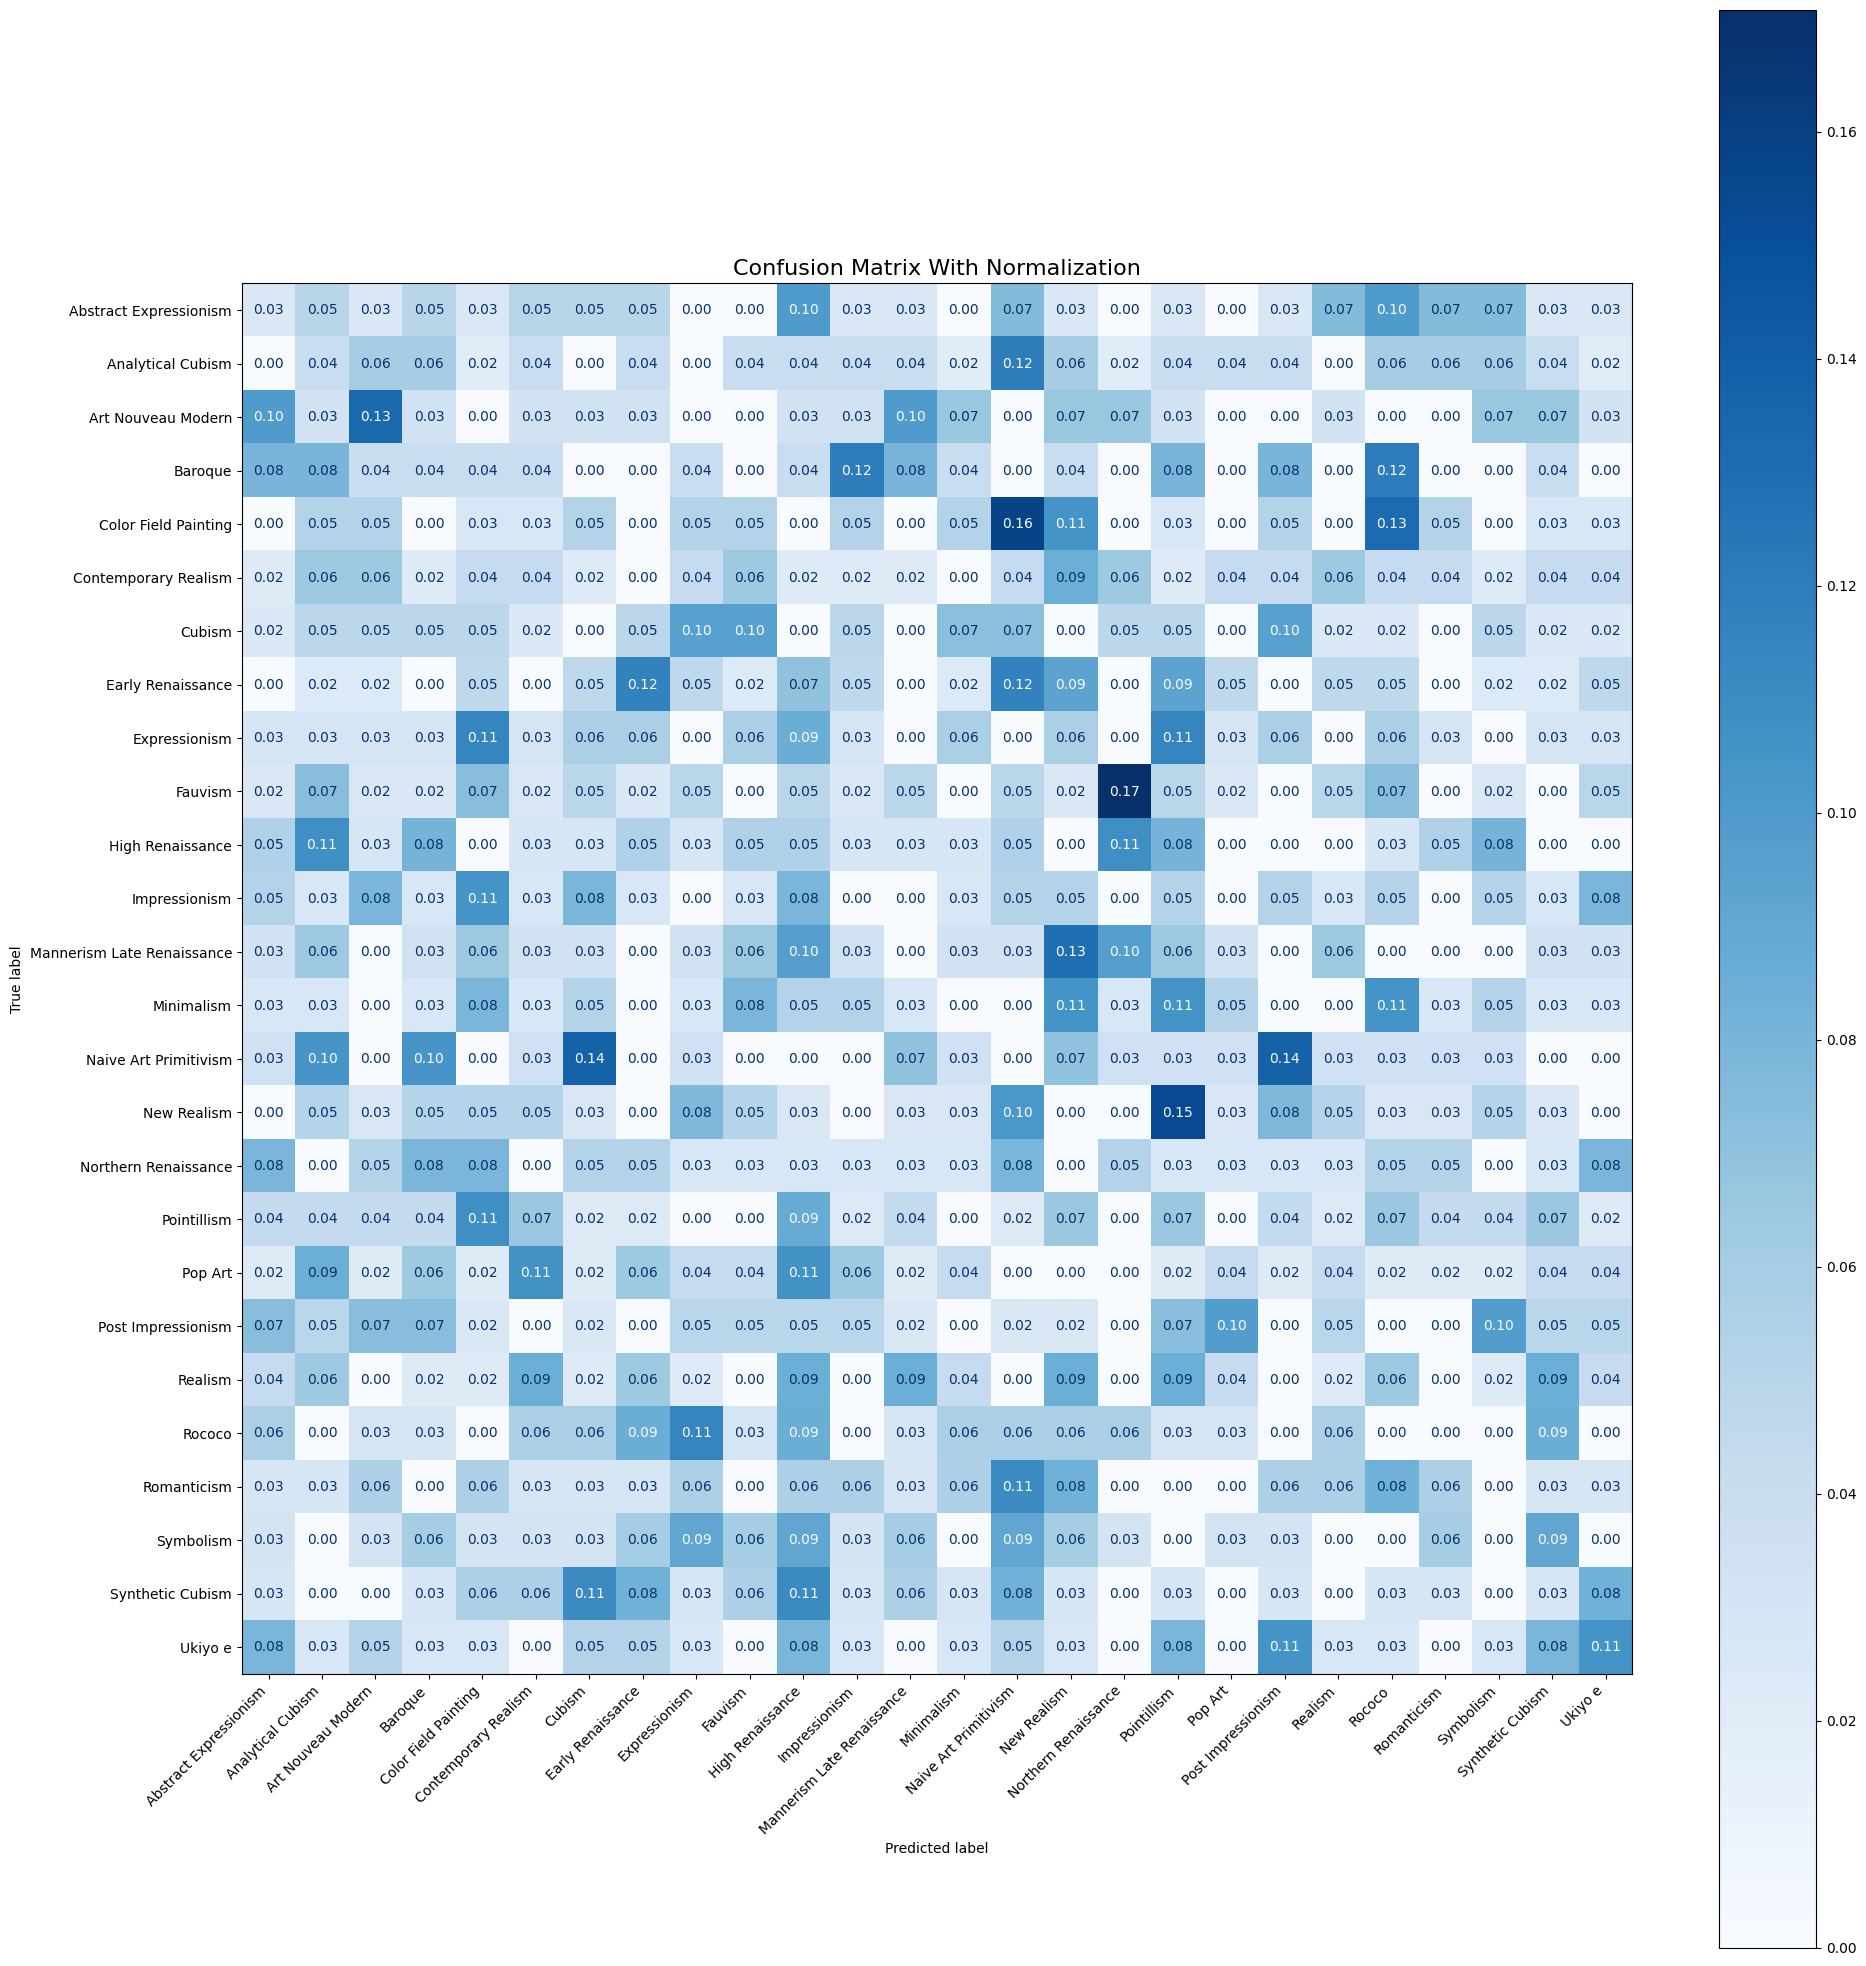

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model  # You can skip this line

# Path to your dataset
dataset_dir = '/content/drive/MyDrive/paintings'  # Update with the path to your dataset directory

# Using ImageDataGenerator to load data
datagen = ImageDataGenerator(rescale=1./255)  # Rescaling pixel values to [0, 1]

# Load data from the directory
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # Resize images to the target size
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for integer labels (default)
    shuffle=False  # Important for later to match predictions with actual labels
)

# Retrieve the classes and their respective indices
classes = list(train_generator.class_indices.keys())

# Evaluate model performance
y_true = train_generator.classes  # True labels
y_pred = model.predict(train_generator, steps=train_generator.samples // train_generator.batch_size)

# Get predicted class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate F1-scores for each class
f1_scores = f1_score(y_true, y_pred_classes, average=None)

# Confidence scores for each class (softmax output probabilities)
confidence_scores = {cls: [] for cls in classes}
for i, cls in enumerate(classes):
    confidence_scores[cls] = y_pred[:, i]  # Extracting softmax probabilities

# Plot confidence score curves for each class
num_classes = len(classes)
cols = 4  # Number of columns in the plot
target_height = (num_classes + cols - 1) // cols  # Rows needed

fig, axes = plt.subplots(target_height, cols, figsize=(10, 10))
axes = axes.ravel()

for idx, cls in enumerate(classes):
    axes[idx].hist(confidence_scores[cls], bins=10, color="blue", alpha=0.7)
    axes[idx].set_title(cls, fontsize=12)
    axes[idx].set_xlabel("Confidence Score", fontsize=8)
    axes[idx].set_ylabel("Frequency", fontsize=8)
    axes[idx].tick_params(axis='both', labelsize=8)

# Hide unused subplots
for idx in range(num_classes, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle("Confidence Score Distribution for Each Class", fontsize=16, y=1.02)
plt.show()

# Plot the F1-scores
plt.figure(figsize=(12, 8))
plt.barh(classes, f1_scores, color="skyblue")
plt.xlabel("F1-Score", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.title("F1-Score for Each Class", fontsize=16)
plt.xlim(0, 1)

# Add scores to bars
for i, score in enumerate(f1_scores):
    plt.text(score + 0.01, i, f"{score:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Confusion Matrix (without normalization)
cm_test = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(20, 20))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
cm_test_normalized = np.nan_to_num(cm_test.astype('float') / cm_test.sum(axis=1, keepdims=True))
plt.figure(figsize=(20, 20))
sns.heatmap(cm_test_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()
